In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

***

**NOTA: Estos modelos ya usan *bias* y cuentan con funciones de activación en las capas ocultas y en la capa de salida.**  

**NOTA_2: Debido a que mi objetivo ahora es comparar los errores de validación vs los errores sobre los datos de entrenamiento, he decido no agregar la opción de interrumpir el entrenamiento una vez se alcance el error de entrenamiento mínimo deseado. Este tipo de enfoque se da en el framework keras.**

***

Cargamos y preprocesamos los datos a ingresar a la red:

In [2]:
from mnist import MNIST

Datos_MNIST = MNIST("MNIST_dataset") # Cargamos la totalidad de datos de MNIST.

imagenes_entrenamiento, etiquetas_entrenamiento = Datos_MNIST.load_training() # Cargando datos de entrenamiento.
imagenes_testeo, etiquetas_testeo = Datos_MNIST.load_testing() # Cargando datos para probar nuestra red una vez se halla entrenado.

imagenes_entrenamiento, etiquetas_entrenamiento = np.asarray(imagenes_entrenamiento), np.asarray(etiquetas_entrenamiento)
imagenes_testeo, etiquetas_testeo = np.asarray(imagenes_testeo), np.asarray(etiquetas_testeo)

imagenes_entrenamiento = (imagenes_entrenamiento/imagenes_entrenamiento.max()).astype("float64")
imagenes_testeo = (imagenes_testeo/imagenes_testeo.max()).astype("float64")

In [3]:
def one_hot_encode (etiquetas):
    """Esta función nos arroja un vector one_hot para cada etiqueta."""
    
    cantidad_clases = len(set(etiquetas))
    vector_OneHot = np.zeros(shape=(etiquetas.shape[0], cantidad_clases), dtype="float64")
    
    for i in range(vector_OneHot.shape[0]):
        vector_OneHot[i,etiquetas[i]] = 1
        
    return vector_OneHot

In [4]:
etiquetas_entrenamiento_ONE_HOT = one_hot_encode(etiquetas_entrenamiento)
etiquetas_testeo_ONE_HOT = one_hot_encode(etiquetas_testeo)

In [5]:
Datos_Entrenamiento = imagenes_entrenamiento[:50000]
Etiquetas_Entrenamiento = etiquetas_entrenamiento_ONE_HOT[:50000]

Datos_Validacion = imagenes_entrenamiento[50000:]
Etiquetas_Validacion = etiquetas_entrenamiento_ONE_HOT[50000:]

***

Funciones de activación:

In [6]:
# FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:

ReLU = lambda x: (x > 0)*x
Leaky_ReLU = lambda arreglo_datos: np.asarray([valor if (valor > 0) else 0.01*valor for vector_x_datos in arreglo_datos 
                                                        for valor in vector_x_datos]).reshape(arreglo_datos.shape)
Tangente_H = lambda x: np.sinh(x)/np.cosh(x)
Sigmoide = lambda x: 1/(1 + np.exp(-x)) # Dependiendo de nuestro proyecto, podemos ocupar esta función para la capa de salida.

# FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS DE SALIDA:

Softmax = lambda vector: np.asarray([np.exp(x)/sum(np.exp(x)) for x in vector])

Derivadas de las funciones de activación:

In [7]:
# DERIVADAS DE LAS FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:

ReLU_Derivada = lambda x: (x > 0)*1 # Si x > 0 devuelve 1, de lo contario 0.

# Si x > 0 devuelve 1, de lo contrario 0.01:
Leaky_ReLU_Derivada = lambda arreglo_datos: np.asarray([1 if (valor > 0) else 0.01 for vector_x_datos in arreglo_datos 
                                                        for valor in vector_x_datos]).reshape(arreglo_datos.shape)

# En términos de los valores de salida, así la backpropagation es menos costosa (computacionalmente hablando):
Tangente_H_Derivada = lambda x: 1 - x**2 # 1 - predicción^2
Sigmoide_Derivada = lambda x: x*(1 - x) # predicción * (1 - predicción)


# DERIVADA DE LA FUNCIÓN DE ACTIVACIÓN PARA LA CAPA DE SALIDA:

Softmax_Derivada = lambda arreglo_datos, arreglo_etiquetas: np.asarray([vector_x_dato - etiquetas_x_dato 
                                                                 for vector_x_dato,etiquetas_x_dato in zip(arreglo_datos,arreglo_etiquetas)])

Creamos una función para inicializar los Pesos y los Bias, es decir, los parámetros:

In [8]:
def inicializacion_parametros (n_x_c):
    """Esta función inicializa los parámetros de nuestra red."""
    
    # INICIALIZAMOS TODOS LOS "BIAS" EN 0:
    
    Bias = [np.zeros(shape=(i,)) for i in n_x_c[1:]] # n_x_c = neuronas por capa.
    
    # NOTA: La lista (para el Bias), comienza a correr desde el segundo elemento, debido a que las neuronas de la capa de entrada no tiene Bias.
    
    # INICIALIZAMOS LOS PESOS HACIENDO USO DEL MÉTODO DE "GLOROT" (TAMBIÉN CONOCIDO COMO "XAVIER"):
    
    Pesos = [np.random.normal(0.0,np.sqrt(2/(n_x_c[i-1] + n_x_c[i])), (n_x_c[i-1], n_x_c[i]))
                        for i in range(1,len(n_x_c))] # n_x_c = neuronas por capa.
    
    return Pesos, Bias

Los **Bias** siempre deben inicializarse en 0.

Los **Pesos** deben inicializarse haciendo uso de la inicialización conocida como *Glorot o Xavier*. Se trata de una distribución Gaussiana cuya media se encuentra en 0 y su desviación estándar esta dada por la fórmula: $$\sqrt{\frac{2}{(CantidadNeuronas^{\textbf{c-1}} + CantidadNeuronas^{\textbf{c}})}}$$
  
Blog de teoría sobre la inicialización de los parámetros:

https://jamesmccaffrey.wordpress.com/2017/06/21/neural-network-glorot-initialization/#:~:text=One%20common%20initialization%20scheme%20for,fan%2Dout%20of%20the%20weight.

https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

***

Inicializamos las funciones restantes que nos serviran para entrenar nuestros modelos:

In [9]:
def generador(x):
    """Esta función nos devuelve el número siguiente cada que éste es solcitado, permitiendo ahorrar memoria."""
    
    for i in range(x):
        
        yield i

In [10]:
def FeedForward(Pesos, Bias, Error_x_lote, entradas, salidas, FA_CO, FA_CS): # n_x_c = neuronas x capa oculta.
    """Esta función lleva a cabo la propagación hacia adelante."""
            
    Vector_x_Capa = list() # Esta lista guardará los vectores de predicción de cada capa.
            
    Capa_Previa = entradas.copy()
                
    # FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:
    
    # NOTA: La lista comienza a correr desde el segundo elemento, debido a que la cantidad de parámetros siempre es igual a:
    # El número de capas - 1, es decir, si hay 4 capas, habrá 3 conjuntos de parámetros en total. Por cada 2 capas hay un arreglo de pesos
    # y otro de Bias.
    
    # NOTA 2: A la función range() se le resta 1 al final, debido a que la suma ponderada final va a pasar a través de la función de activación
    # de la capa de salida, la cual es diferente.
    
    if FA_CO == 0: # ReLU.
                
        for j in range(len(Pesos)-1):
            
            Capa_Previa = ReLU(Capa_Previa @ Pesos[j] + Bias[j])
            Vector_x_Capa.append(Capa_Previa)
                
    elif FA_CO == 1: # Leaky_ReLU.
                
        for j in range(len(Pesos)-1):
                
            Capa_Previa = Leaky_ReLU(Capa_Previa @ Pesos[j] + Bias[j])
            Vector_x_Capa.append(Capa_Previa)
                    
    elif FA_CO == 2: # Tangente Hiperbólica.
                
        for j in range(len(Pesos)-1):
                
            Capa_Previa = Tangente_H(Capa_Previa @ Pesos[j] + Bias[j])
            Vector_x_Capa.append(Capa_Previa)
                    
    elif FA_CO == 3: # Sigmoide.
                
        for j in range(len(Pesos)-1):
                
            Capa_Previa = Sigmoide(Capa_Previa @ Pesos[j] + Bias[j])
            Vector_x_Capa.append(Capa_Previa)
                
    
    # FUNCIONES DE ACTIVACIÓN PARA LA CAPA DE SALIDA:
    
    if FA_CS == 0: # Softmax.
                    
        Capa_Previa = Softmax(Capa_Previa @ Pesos[-1] + Bias[-1])
        Vector_x_Capa.append(Capa_Previa)
                
        # Tipo de Error: Entropía Categórica Cruzada (-ln(Predicción)).
        Vector_Columna_Softmax = np.sum(Capa_Previa*salidas,axis=1).reshape(-1,1)
        Funcion_Error_x_Cada_Muestra = (-1)*(np.log(Vector_Columna_Softmax)) # Vector de Funciones de Error x cada Muestra.
        
        Error_x_lote += sum(Funcion_Error_x_Cada_Muestra) / len(Vector_Columna_Softmax) # Promediamos las funciones de error x cada muestra.
                
    else: # Sigmoide.
                    
        Capa_Previa = Sigmoide(Capa_Previa @ Pesos[-1] + Bias[-1])
        Vector_x_Capa.append(Capa_Previa)
        
        # Tipo de Error: Error Cuadrático ((Predicción - Salida_Deseada)^2).
        Funcion_Error_x_Cada_Muestra = (Capa_Previa - salidas)**2 # Vector de Funciones de Error x cada Muestra.
        
        Error_x_lote += np.sum(Funcion_Error_x_Cada_Muestra) / len(salidas) # Promediamos las funciones de error x cada muestra.
        
    # NOTA: NO OLVIDEMOS QUE QUIEN SE DERIVA ES LA FUNCIÓN DE ERROR POR MUESTRA, NO EL PROMEDIO DE ESTAS.
        
    return Vector_x_Capa, Error_x_lote

In [11]:
def BackPropagation(Predicciones_x_Capa, Pesos, salidas, FA_CO, FA_CS):
    """Esta función ejecuta el algoritmo de backpropagation, el cual es el encargado de reducir el error, es decir, se encarga
    del aprendizaje de nuestra red."""
    
    # CALCULAMOS LOS ERRORES DELTA (O DELTAS), DE LAS NEURONAS DE LA CAPA DE SALIDA:
    
    Errores_Delta = list()
    
    if FA_CS == 0: # Si la función de activación de la capa de salida es Softmax.
        
        Deltas_Capa_Salida = Predicciones_x_Capa[-1] - salidas
    
    else: # Si la función de activación de la capa de salida es Sigmoide.
        
        Deltas_Capa_Salida = (2*(Predicciones_x_Capa[-1] - salidas)*1) * \
        (Predicciones_x_Capa[-1] * (1 - Predicciones_x_Capa[-1]))
        
    Errores_Delta.append(Deltas_Capa_Salida)
    
    # CALCULAMOS LOS ERRORES DELTA (O DELTAS), DE LAS NEURONAS DE LAS CAPAS OCULTAS:
    
    if FA_CO == 0: # ReLU.
        
        Derivadas_ReLU = [ReLU_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
            
            Deltas = Derivadas_ReLU[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
        
    elif FA_CO == 1: # Leaky_ReLU.
                
        Derivadas_Leaky_ReLU = [Leaky_ReLU_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
                
            Deltas = Derivadas_Leaky_ReLU[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
                    
    elif FA_CO == 2: # Tangente Hiperbólica.
        
        Derivadas_TanH = [Tangente_H_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
                
            Deltas = Derivadas_TanH[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
                    
    else: # Sigmoide.
        
        Derivadas_Sigmoide = [Sigmoide_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
                
            Deltas = Derivadas_Sigmoide[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
            
    return Errores_Delta # o Deltas, simplemente.

In [12]:
def Actualizacion_Parametros(tamaño_lote, Errores_Delta, entradas, Predicciones_x_Capa, Pesos, Bias, alfa):
    """Esta función lleva a cabo la actualización de los Pesos y de los Bias de toda la red."""
    
    # REALIZAMOS UNOS PEQUEÑOS AJUSTES PREVIO A INICIAR LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Predicciones_x_Capa.insert(0, entradas) # Agregamos el valor de las entradas para poder calcular el
    # gradiente promedio de los parámetros de la primer capa (o más precisamente, de los parámetros que se encuentran entre la capa de entrada
    # y la 1er capa oculta).
    
    Errores_Delta.reverse() # Dado que los deltas de la capa de salida se guardaron primero y los deltas de la 1er capa oculta se guardaron
    # al último, necesitamos revertir el order de la lista, para que los delta de la 1er capa oculta se encuentren al principio y, los delta
    # de la capa de salida al final.
    
    # COMIENZA LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Pesos = [Pesos[j] - alfa * (Predicciones_x_Capa[j].T.dot(Errores_Delta[j]) / tamaño_lote) 
                        for j in range(len(Errores_Delta))]
    
    Bias = [Bias[j] - alfa * (sum(Errores_Delta[j]) / tamaño_lote) 
                        for j in range(len(Errores_Delta))]
    
    return Pesos, Bias

In [186]:
def precision_y_validacion(Pesos, Bias, entradas, etiquetas, FA_CO, FA_CS):
    """Esta función calcula la precisión y el error sobre los datos ingresados."""
    
    assert FA_CS == 0, "ESTA FUNCIÓN NO ESTA PENSADA PARA VALIDAR DATOS EN REDES CUYA FUNCIÓN DE ACTIVACIÓN EN LA CAPA DE SALIDA SEA DISTINTA \
    A SOFTMAX."
    
    Error = 0
            
    Predicciones, Error = FeedForward(Pesos, Bias, Error, entradas, etiquetas, FA_CO, FA_CS)
    
    Aciertos = (np.argmax(Predicciones[-1], axis=1) == np.argmax(etiquetas, axis=1)).sum()
    
    Precision = (Aciertos / len(etiquetas)) * 100
    
    return Precision, Error*100

In [14]:
def predicciones(Pesos, Bias, entradas, salidas, FA_CO, FA_CS):
    """Esta función realiza inferencia haciendo uso de un modelo entrenado."""
    
    Error_x_lote = 0
    
    Vector_Prediccion, Error_Prediccion = FeedForward(Pesos, Bias, Error_x_lote, entradas, salidas, FA_CO, FA_CS)
    
    return Vector_Prediccion[-1], Error_Prediccion*100

**Inicia el algoritmo de entrenamiento:**

In [187]:
from timeit import default_timer

def algoritmo_entrenamiento (entradas, salidas, epocas, tamaño_lote, entradas_validacion=None, etiquetas_validacion=None):
    """Esta función ejecuta el algoritmo de entrenamiento para nuestra red neuronal."""
    
    assert len(entradas.shape) == 2, "EL VECTOR O MATRIZ DE ENTRADA DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
    assert len(salidas.shape) == 2, "EL VECTOR O MATRIZ DE SALIDA DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
    assert len(entradas) % tamaño_lote == 0, "EL TAMAÑO DEL LOTE DEBE SER DIVISOR DEL TOTAL DE MUESTRAS DE ENTRADA."
    
    # Inicializamos los Hyperparámetros de nuestra red:
    
    print("\nPor default, tienes una sola capa de entrada. Por lo tanto...")
    capas_ocultas = int(input("Cuantas capas ocultas deseas?: "))
    print("Finalmente y por default, tienes una sola capa de salida.\n")
    print(f"'Tu Red Neuronal cuenta con 1 Capa de Entrada, {capas_ocultas} Capas Ocultas y 1 Capa de Salida'.\n")
    
    texto = "'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,"
    texto += "\nel programa selecciona de manera automática el número de neuronas de entrada por tí'.\n"
    print(texto)
    
    n_x_c = list() # Neuronas Por Capa.
    
    for capa in range(capas_ocultas):
        
        n_x_c.append(int(input(f"Cuántas neuronas deseas para la capa oculta {capa+1}: ")))
        
    n_x_c.append(int(input("Cuántas neuronas deseas para la capa de salida: ")))
    assert n_x_c[-1] == salidas.shape[1], "EL NÚMERO DE NEURONAS DE SALIDA DEBE SER IGUAL AL NÚMERO DE ENTRADAS EN EL VECTOR DE SALIDA."
    
    n_x_c.insert(0, entradas.shape[1]) # Agregamos el número de neuronas de entrada al principio de nuestra lista.
    
    alfa = float(input("\nQué valor deseas para la tasa de aprendizaje: "))
    
    # Seleccionamos la Función de Activación para las Capas Ocultas:
    FA_CO = int(input("\nQué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3)"))
    assert FA_CO in [0,1,2,3], "SELECCIONA UNA FUNCIÓN DE ACTIVACIÓN VÁLIDA PARA LAS CAPAS OCULTAS."
    
    # Seleccionamos la Función de Activación para la Capa de Salida:
    FA_CS = int(input("Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1)"))
    assert FA_CS in [0,1], "SELECCIONA UNA FUNCIÓN DE ACTIVACIÓN VÁLIDA PARA LA CAPA DE SALIDA."
    
    # Datos de validación:
    if type(entradas_validacion) == np.ndarray and type(etiquetas_validacion) == np.ndarray:
        assert len(entradas_validacion.shape) == 2, "LOS DATOS DE VALIDACIÓN DEBEN TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
        assert len(etiquetas_validacion.shape) == 2, "LAS ETIQUETAS DE VALIDACIÓN DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
        assert FA_CS == 0, "PARA NUESTRO CASO, CUANDO HAGAMOS USO DE LOS DATOS DE VALIDACIÓN NO PLANEAMOS USAR SIGMOIDE EN LA CAPA DE SALIDA."

        validar = True
        
    else:
        
        validar = False
    
    # Lotes:
    cantidad_lotes = len(entradas) / tamaño_lote
    print(f"\nLa cantidad de lotes a ingresar a la red es: {cantidad_lotes}.\n")
    
    # Inicializamos los Parámetros de nuestra red:
    
    Pesos, Bias = inicializacion_parametros(n_x_c)
    
    # Inicializamos las listas requeridas para guardar los datos necesarios:
    
    Errores_Entrenamiento = list()
    Precision_Entrenamiento = list()
    
    Errores_Validacion = list()
    Precision_Validacion = list()
    
    # Inicializamos nuestro timer para observar el tiempo total de entrenamiento:
    inicio = default_timer()
    
    for epoca in generador(epocas):
        
        Error_x_lote = 0
        
        for i in range(int(len(entradas)/tamaño_lote)): # Las muestras pasan por lote.
            
            salidas_lote = salidas[(i*tamaño_lote):((i+1)*tamaño_lote),:]
            entradas_lote = entradas[(i*tamaño_lote):((i+1)*tamaño_lote),:]
            
            # INICIA LA PROPAGACIÓN HACIA ADELANTE (FORWARD-PROPAGATION).
            
            Predicciones_x_Capa, Error_x_lote = FeedForward(Pesos, Bias, Error_x_lote, entradas_lote, salidas_lote, FA_CO, FA_CS)
            
            # INICIA LA BACKPROPAGATION.
            
            Errores_Delta = BackPropagation(Predicciones_x_Capa, Pesos, salidas_lote, FA_CO, FA_CS)
            Pesos, Bias = Actualizacion_Parametros(tamaño_lote, Errores_Delta, entradas_lote, Predicciones_x_Capa, Pesos, Bias, alfa)
            
        print(f"Época: {epoca + 1}")
            
        # VALIDAMOS NUESTRO MODELO (SI ASÍ SE DESEA):
        
        if validar:
            
            Precision_V, Error_V = precision_y_validacion(Pesos, Bias, entradas_validacion, etiquetas_validacion, FA_CO, FA_CS)
            
            Precision_Validacion.append(Precision_V)
            Errores_Validacion.append(Error_V)
            
            print(f"Precisión en los Datos de Validación: {Precision_V}%")
            print(f"Error en los Datos de Validación: {Error_V}%")
            
        # ERROR Y PRECISIÓN DE LA RED EN LOS DATOS DE ENTRENAMIENTO.
        
        if FA_CS == 1: # Si la función de activación para la capa de salida es Sigmoide.
            
            Error_x_epoca = (Error_x_lote / cantidad_lotes)*100 # "Error Cuadrático Medio" dado en Porcentaje.
            
        else: # Si la función de activación para la capa de salida es Softmax.
            
            Error_x_epoca = (Error_x_lote / cantidad_lotes)*100 # "Error Logarítmico Promedio" dado en Porcentaje.
        
            Precision_E, _ = precision_y_validacion(Pesos, Bias, entradas, salidas, FA_CO, FA_CS)

            Precision_Entrenamiento.append(Precision_E)
            Errores_Entrenamiento.append(Error_x_epoca)

            print(f"Precisión en los Datos de Entrenamiento: {Precision_E}%")
            
        print(f"Error Total de la Red sobre los Datos de Entrenamiento: {np.around(Error_x_epoca, 10)}%\n")
    
    Tiempo_total = np.around(default_timer() - inicio, decimals=4)
    
    if Tiempo_total < 60:
        
        print(f"Tiempo Total de Entrenamiento: {Tiempo_total} segundos.\n")
        
    else:
        
        print(f"Tiempo Total de Entrenamiento: {Tiempo_total / 60} minutos.\n")
    
    if validar:
        
        return Pesos, Bias, Errores_Entrenamiento, Errores_Validacion, Precision_Entrenamiento, Precision_Validacion, FA_CO, FA_CS
    
    else:
        
        return Pesos, Bias, Errores_Entrenamiento, Precision_Entrenamiento, FA_CO, FA_CS

***

#### **Recuerda que la función de activación de salida Softmax, se usa cuando la clasificación es multiclase, mientras que Sigmoide se ocupa cuando se trata de una clasificación binaria**. Sin embargo, y de acuerdo al proyecto que nos encontremos desarrollando, podriamos hacer uso de la función de activación Sigmoide en la capa de salida.

***

**FA_CO** = Función de Activación de la(s) Capa(s) Oculta(s).  
**FA_CS** = Función de Activación de la Capa de Salida.  

**E_E** = Errores de la red en los datos de entrenamiento.  
**E_V** = Errores de la red en los datos de validación.  

**P_E** = Precisión de la red en los datos de entrenamiento.  
**P_V** = Precisión de la red en los datos de validación.

#### **A continuación, realizaremos un modelo por cada FA para las Capas Oculatas y compararemos sus resultados.**
#### La arquitectura es: **784 neuronas de entrada, 512 neuronas en la capa oculta, 10 neuronas en la capa de salida, alfa = 0.98, Softmax como función de activación en la capa de salida y como función de activación para la capa oculta usaremos ReLU, Leaky_ReLU, TanH o Sigmoide, según corresponda.

**Para ReLU:**

In [16]:
epocas = 10
tamaño_lote = 200

Pesos_ReLU, Bias_ReLU, E_E_ReLU, E_V_ReLU, P_E_ReLU, P_V_ReLU, FA_CO_ReLU, FA_CS_ReLU = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3) 0
Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1) 0



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 94.69%
Error en los Datos de Validación: [18.44283484]%
Precisión en los Datos de Entrenamiento: 93.85%
Error Total de la Red sobre los Datos de Entrenamiento: [36.76277088]%

Época: 2
Precisión en los Datos de Validación: 96.48%
Error en los Datos de Validación: [11.55788125]%
Precisión en los Datos de Entrenamiento: 96.74199999999999%
Error Total de la Red sobre los Datos de Entrenamiento: [12.43864757]%

Época: 3
Precisión en los Datos de Validación: 97.23%
Error en los Datos de Validación: [9.31342433]%
Precisión en los Datos de Entrenamiento: 97.932%
Error Total de la Red sobre los Datos de Entrenamiento: [8.48502605]%

Época: 4
Precisión en los Datos de Validación: 97.59%
Error en los Datos de Validación: [8.20280771]%
Precisión en los Datos de Entrenamiento: 98.5%
Error Total de la Red sobre los Datos de Entrenamiento: [6.24685028]%

Época: 5
Precisión en los Datos de Validación:

In [17]:
Prediccion_Testeo_ReLU, Error_Testeo_ReLU = predicciones(Pesos_ReLU, Bias_ReLU, imagenes_testeo, etiquetas_testeo_ONE_HOT, 
                                                          FA_CO_ReLU, FA_CS_ReLU)

In [124]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_ReLU, decimals=4)}%.")

Aciertos_Testeo_ReLU = (np.argmax(Prediccion_Testeo_ReLU,1) == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_ReLU}")

P_T_ReLU = (Aciertos_Testeo_ReLU / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_ReLU}%")

Error sobre los datos de Testeo: [6.9575]%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9805
Porcentaje de Precisión sobre los datos de Testeo: 98.05%


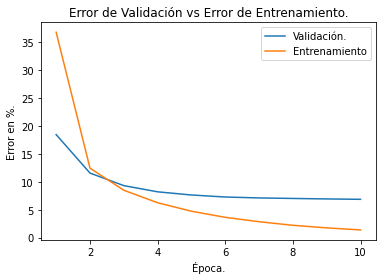

In [19]:
epocas = range(1,len(E_V_ReLU)+1)

plt.plot(epocas, E_V_ReLU, label="Validación.")
plt.plot(epocas, E_E_ReLU, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

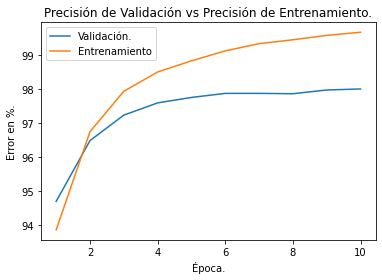

In [20]:
epocas = range(1,len(P_V_ReLU)+1)

plt.plot(epocas, P_V_ReLU, label="Validación.")
plt.plot(epocas, P_E_ReLU, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

In [21]:
print(f"Error de la red en la última época sobre los Datos de Validación: {E_V_ReLU[-1]}%")
print(f"Error de la red en la última época sobre los Datos de Entrenamiento: {E_E_ReLU[-1]}%")

Error de la red en la última época sobre los Datos de Validación: [6.86097814]%
Error de la red en la última época sobre los Datos de Entrenamiento: [1.38505395]%


***

#### *¿Por qué el error de validación, entrenamiento y/o testeo parece alto, pero las predicciones son favorables?*

La respuesta a esta pregunta es sencilla.

Supongamos los siguientes vectores de predicción (El primer vector corresponde a la predicción sobre una muestra en el conjunto de entrenamiento, mientras que el segudo, corresponde a una muestra en el conjunto de datos de testeo):  

$[0.4, 0.99, 0.6]$ y $[0.1, 0.3, 0.2]$

**Ambos vectores corresponden al número 1**, por ello, la etiqueta correspondiente preproceda y convertida en un vector one-hot encode, es la siguiente:

$[0, 1, 0]$

Por ende, y haciendo uso de la función de error *Entropía Categorica Cruzada*, tenemos que para el primer vector:  

$[0.4, 0.99, 0.6] * [0, 1, 0] = 0.99 -> -ln(0.99) = 0.01005$

Por lo tanto, el error es **1.005%** para la predicción sobre la muestra en el conjunto de entrenamiento. Por otro lado, para el segundo vector se tiene lo siguiente:

$[0.1, 0.7, 0.2] * [0, 1, 0] = 0.7 -> -ln(0.7) = 0.3566$

El error para la predicción sobre la muestra en el conjunto de datos de testeo es **35.66%**, como podemos observar el error es enorme. Sin embargo, recordemos que la predicción corresponde a la posición del valor más alto, por lo tanto, el valor más alto en ambos vectores se encuentra en la posición número 1, es decir, ambas predicciones indican que el dato ingresado en nuestra "red" corresponde al número 1, por ende, **ambas predicciones son correctas**, aún y con la diferencia significativa que existe entre los errores de ambas muestras. Lo anterior siempre occurre al entrenar una red neuronal con salidas probabilísticas; el error por muestra o por lote va disminuyendo en cada época de entrenamiento, pero dado que el valor arrojado por cada vector de predicción no es 100% exacto, los errores, aunque pequeños, se van acumulando. 

Finalmente y como conclusión, aunque la inferencia por parte de nuestra red sea buena, siempre será mejor un modelo cuyo porcentaje de error sea pequeño. Desde mi punto de vista y para el conjunto de datos MNIST, ese porcentaje debe ser $<= 6$% sobre los datos de testeo.

***

**Para Leaky_ReLU:**

In [22]:
epocas = 10
tamaño_lote = 200

Pesos_Leaky_ReLU, Bias_Leaky_ReLU, E_E_Leaky_ReLU, E_V_Leaky_ReLU, P_E_Leaky_ReLU, P_V_Leaky_ReLU, FA_CO_Leaky_ReLU, FA_CS_Leaky_ReLU = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3) 1
Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1) 0



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 94.65%
Error en los Datos de Validación: [18.01813971]%
Precisión en los Datos de Entrenamiento: 94.16600000000001%
Error Total de la Red sobre los Datos de Entrenamiento: [37.26402361]%

Época: 2
Precisión en los Datos de Validación: 95.94%
Error en los Datos de Validación: [13.29056604]%
Precisión en los Datos de Entrenamiento: 96.166%
Error Total de la Red sobre los Datos de Entrenamiento: [12.52910323]%

Época: 3
Precisión en los Datos de Validación: 96.53%
Error en los Datos de Validación: [10.87924514]%
Precisión en los Datos de Entrenamiento: 97.312%
Error Total de la Red sobre los Datos de Entrenamiento: [8.57631749]%

Época: 4
Precisión en los Datos de Validación: 97.18%
Error en los Datos de Validación: [9.1612764]%
Precisión en los Datos de Entrenamiento: 98.20400000000001%
Error Total de la Red sobre los Datos de Entrenamiento: [6.32891287]%

Época: 5
Precisión en los Datos 

In [23]:
Prediccion_Testeo_Leaky_ReLU, Error_Testeo_Leaky_ReLU = predicciones(Pesos_Leaky_ReLU, Bias_Leaky_ReLU, imagenes_testeo, 
                                                                     etiquetas_testeo_ONE_HOT, FA_CO_Leaky_ReLU, FA_CS_Leaky_ReLU)

In [125]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_Leaky_ReLU, decimals=4)}%.")

Aciertos_Testeo_Leaky_ReLU = (np.argmax(Prediccion_Testeo_Leaky_ReLU,1) == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_Leaky_ReLU}")

P_T_Leaky_ReLU = (Aciertos_Testeo_Leaky_ReLU / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_Leaky_ReLU}%")

Error sobre los datos de Testeo: [6.7437]%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9799
Porcentaje de Precisión sobre los datos de Testeo: 97.99%


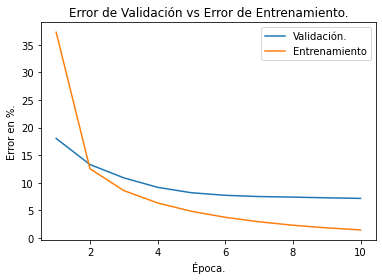

In [25]:
epocas = range(1,len(E_V_Leaky_ReLU)+1)

plt.plot(epocas, E_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, E_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

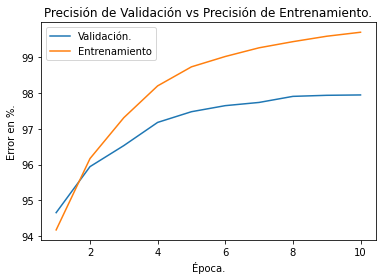

In [26]:
epocas = range(1,len(P_V_Leaky_ReLU)+1)

plt.plot(epocas, P_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, P_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

In [27]:
print(f"Error de la red en la última época sobre los Datos de Validación: {E_V_Leaky_ReLU[-1]}%")
print(f"Error de la red en la última época sobre los Datos de Entrenamiento: {E_E_Leaky_ReLU[-1]}%")

Error de la red en la última época sobre los Datos de Validación: [7.15494776]%
Error de la red en la última época sobre los Datos de Entrenamiento: [1.44516496]%


**Para Tangente Hiperbólica:**

In [40]:
epocas = 10
tamaño_lote = 200

Pesos_TanH, Bias_TanH, E_E_TanH, E_V_TanH, P_E_TanH, P_V_TanH, FA_CO_TanH, FA_CS_TanH = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3) 2
Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1) 0



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 89.8%
Error en los Datos de Validación: [115.58562118]%
Precisión en los Datos de Entrenamiento: 88.774%
Error Total de la Red sobre los Datos de Entrenamiento: [1994.42869867]%

Época: 2
Precisión en los Datos de Validación: 92.36999999999999%
Error en los Datos de Validación: [79.71629565]%
Precisión en los Datos de Entrenamiento: 91.33%
Error Total de la Red sobre los Datos de Entrenamiento: [116.62402127]%

Época: 3
Precisión en los Datos de Validación: 90.91%
Error en los Datos de Validación: [81.6557432]%
Precisión en los Datos de Entrenamiento: 90.042%
Error Total de la Red sobre los Datos de Entrenamiento: [64.52418045]%

Época: 4
Precisión en los Datos de Validación: 86.86%
Error en los Datos de Validación: [107.23027819]%
Precisión en los Datos de Entrenamiento: 86.506%
Error Total de la Red sobre los Datos de Entrenamiento: [47.42561015]%

Época: 5
Precisión en los Datos de V

In [41]:
Prediccion_Testeo_TanH, Error_Testeo_TanH = predicciones(Pesos_TanH, Bias_TanH, imagenes_testeo, 
                                                                     etiquetas_testeo_ONE_HOT, FA_CO_TanH, FA_CS_TanH)

In [122]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_TanH, decimals=4)}%.")

Aciertos_Testeo_TanH = (np.argmax(Prediccion_Testeo_TanH,1) == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_TanH}")

P_T_TanH = (Aciertos_Testeo_TanH / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_TanH}%")

Error sobre los datos de Testeo: [19.3182]%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9669
Porcentaje de Precisión sobre los datos de Testeo: 96.69%


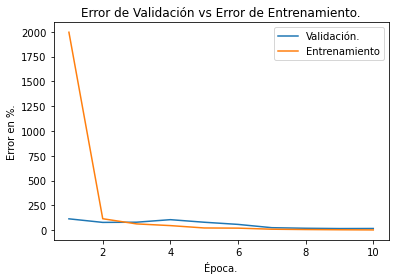

In [43]:
epocas = range(1,len(E_V_TanH)+1)

plt.plot(epocas, E_V_TanH, label="Validación.")
plt.plot(epocas, E_E_TanH, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

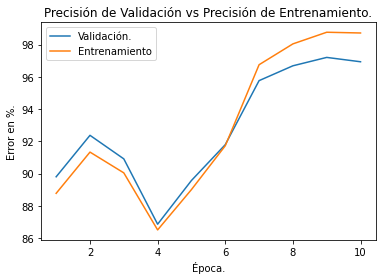

In [44]:
epocas = range(1,len(P_V_TanH)+1)

plt.plot(epocas, P_V_TanH, label="Validación.")
plt.plot(epocas, P_E_TanH, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

In [45]:
print(f"Error de la red en la última época sobre los Datos de Validación: {E_V_TanH[-1]}%")
print(f"Error de la red en la última época sobre los Datos de Entrenamiento: {E_E_TanH[-1]}%")

Error de la red en la última época sobre los Datos de Validación: [18.30753751]%
Error de la red en la última época sobre los Datos de Entrenamiento: [3.99568626]%


**Para Sigmoide:**

In [34]:
epocas = 10
tamaño_lote = 200

Pesos_Sigmoide, Bias_Sigmoide, E_E_Sigmoide, E_V_Sigmoide, P_E_Sigmoide, P_V_Sigmoide, FA_CO_Sigmoide, FA_CS_Sigmoide = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3) 3
Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1) 0



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 89.8%
Error en los Datos de Validación: [34.0886995]%
Precisión en los Datos de Entrenamiento: 88.41799999999999%
Error Total de la Red sobre los Datos de Entrenamiento: [85.86334254]%

Época: 2
Precisión en los Datos de Validación: 92.04%
Error en los Datos de Validación: [27.07053579]%
Precisión en los Datos de Entrenamiento: 91.282%
Error Total de la Red sobre los Datos de Entrenamiento: [30.06335215]%

Época: 3
Precisión en los Datos de Validación: 93.47999999999999%
Error en los Datos de Validación: [22.74132228]%
Precisión en los Datos de Entrenamiento: 92.914%
Error Total de la Red sobre los Datos de Entrenamiento: [24.96877847]%

Época: 4
Precisión en los Datos de Validación: 94.66%
Error en los Datos de Validación: [19.63150297]%
Precisión en los Datos de Entrenamiento: 94.03399999999999%
Error Total de la Red sobre los Datos de Entrenamiento: [21.3115298]%

Época: 5
Precisión 

In [35]:
Prediccion_Testeo_Sigmoide, Error_Testeo_Sigmoide = predicciones(Pesos_Sigmoide, Bias_Sigmoide, imagenes_testeo, 
                                                                     etiquetas_testeo_ONE_HOT, FA_CO_Sigmoide, FA_CS_Sigmoide)

In [123]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_Sigmoide, decimals=4)}%.")

Aciertos_Testeo_Sigmoide = (np.argmax(Prediccion_Testeo_Sigmoide,1) == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_Sigmoide}")

P_T_Sigmoide = (Aciertos_Testeo_Sigmoide / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_Sigmoide}%")

Error sobre los datos de Testeo: [12.1523]%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9624
Porcentaje de Precisión sobre los datos de Testeo: 96.24000000000001%


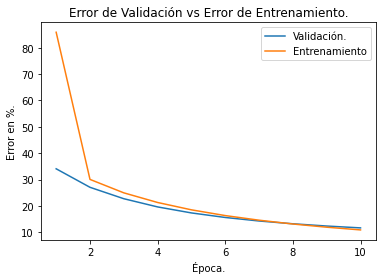

In [37]:
epocas = range(1,len(E_V_Sigmoide)+1)

plt.plot(epocas, E_V_Sigmoide, label="Validación.")
plt.plot(epocas, E_E_Sigmoide, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

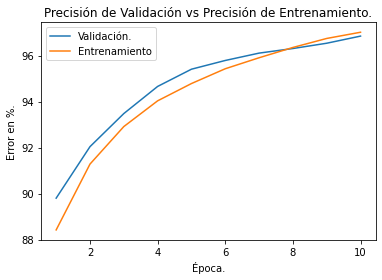

In [38]:
epocas = range(1,len(P_V_Sigmoide)+1)

plt.plot(epocas, P_V_Sigmoide, label="Validación.")
plt.plot(epocas, P_E_Sigmoide, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

In [39]:
print(f"Error de la red en la última época sobre los Datos de Validación: {E_V_Sigmoide[-1]}%")
print(f"Error de la red en la última época sobre los Datos de Entrenamiento: {E_E_Sigmoide[-1]}%")

Error de la red en la última época sobre los Datos de Validación: [11.68063547]%
Error de la red en la última época sobre los Datos de Entrenamiento: [10.91251654]%


***

#### *Es importante notar lo siguiente:*

El error en los datos de testeo cuando se usa como función de activación para las capas ocultas al **sigmoide**, es del $12.1523\%$, mientras que cuando se hace uso de la **tangente hiperbólica** el error en estos datos es del $19.3182\%$. Uno podría pensar en primera instancia, que la función **sigmoide** tuvo una mayor precisión sobre los datos de testeo, debido a que el error es menor que el de la **tangente hiperbólica**. Sin embargo, esto no es así --y aunque la diferencia no es mucha--, los datos inferidos correctamente en el conjunto de testeo haciendo uso de la **tangente hiperbólica** en las capas ocultas es: $9669$, mientras que para la **sigmoide** es: $9624$.

*Lo anterior parece un poco contradictorio, no obstante, esto no es así. **La respuesta a esto se sitúa en los elementos no inferidos correctamente**. Tomemos como ejemplo, las probabilidades de los primeros 9 elementos:*

In [87]:
# Tomamos la probabilidad de cada vector correspondiente a cada muestra de testeo:

Probabilidad_Predicciones_TanH = Prediccion_Testeo_TanH * etiquetas_testeo_ONE_HOT
Probabilidades_TanH = np.asarray([probabilidad for vector in Probabilidad_Predicciones_TanH 
                                  for probabilidad in vector if probabilidad > 0])

Probabilidad_Predicciones_Sigmoide = Prediccion_Testeo_Sigmoide * etiquetas_testeo_ONE_HOT
Probabilidades_Sigmoide = np.asarray([probabilidad for vector in Probabilidad_Predicciones_Sigmoide 
                                      for probabilidad in vector if probabilidad > 0])

In [103]:
# Mostramos las primeras 9 probabilidades:

print(Probabilidades_TanH[:9])
print('\r')
print(Probabilidades_Sigmoide[:9])

[1.00000000e+00 9.99999991e-01 9.99999976e-01 9.99999932e-01
 1.00000000e+00 9.99997672e-01 1.00000000e+00 9.96139951e-01
 6.12892818e-05]

[0.99810304 0.98825226 0.99500387 0.99815409 0.99310731 0.99153584
 0.99383824 0.98424519 0.02114706]


Aquí se muestran las primeras 9 probabilidades correspondientes a las primeras 9 muestras de testeo. Es decir, de cada vector se tomo la probabilidad correspondiente al index de la muestra.

Podemos notar que para ambas funciones de activación en las capas ocultas, la **tangente hiperbólica** presenta una mayor seguridad sobre sus predicciones debido a que el valor de cada probabilidad es mayor que los de la **sigmoide**. No obstante, si prestamos más atención, notaremos que la última probabilidad, es muy pequeña en ambos vectores ($6.12892818e-05$ para la **tangente hiperbólica** y $0.02114706$ para la **sigmoide**). Esto quiere decir, que para la muestra número 9 en el conjunto de testeo, ambos modelos estan seguros de que esta muestra no corresponde a su etiqueta respectiva, es decir:

In [104]:
# Etiqueta real para la muestra número 9:

print(f"Etiqueta correspondiente a la muestra número 9 en el conjunto de testeo: {etiquetas_testeo[8]}")

Etiqueta correspondiente a la muestra número 9 en el conjunto de testeo: 5


In [98]:
# Tangente Hiperbólica:

print(f"Predicción por parte del modelo: {np.argmax(Prediccion_Testeo_TanH[8])}")

Predicción por parte del modelo: 6


In [100]:
# Sigmoide:

print(f"Predicción por parte del modelo: {np.argmax(Prediccion_Testeo_Sigmoide[8])}")

Predicción por parte del modelo: 6


Como se observa, ambos modelos creen que la muestra número 9 pertence al número 6. Sin embargo, esto no es así, la etiqueta correcta es el número 5.

Aquí radica la respuesta, recordemos que al hacer uso de la función de error **entropía categórica cruzada**, una probabilidad cercana a 1 presentará un error menor que una más lejana a este. Por lo tanto, si sumamos los errores correspondientes a cada probabilidad, pero excluyendo a la última --que es la errónea--, obtendremos el siguiente resultado:

**A**

In [107]:
sum((-1)*np.log(Probabilidades_TanH[:8]))

0.0038699472021737533

**B**

In [108]:
sum((-1)*np.log(Probabilidades_Sigmoide[:8]))

0.058050110032966666

Como podemos observar, la suma de los errores es mucho menor en **A** que en **B**. Ahora veamos que ocurre cuando incluimos a la predicción o probabilidad errónea:

**A.1**

In [110]:
sum((-1)*np.log(Probabilidades_TanH[:9]))

9.703775525339216

**B.1**

In [109]:
sum((-1)*np.log(Probabilidades_Sigmoide[:9]))

3.914304601923487

Como podemos observar, la suma ahora es mucho más grande en **A.1** que en **B.1**. Esto se debe a que las probabilidades de los elementos inferidos incorrectamente en el modelo con **tangente hiperbólica** en las capas ocultas, tenderán a ser mucho más cercanas a 0 que con el modelo que hace uso de la **sigmoide** en las capas ocultas. Finalmente, aplicaremos directamente el error **entropía categórica cruzada** sobre las probabilidades pertenecientes a las inferencias realizadas incorrectamente, para observar de manera más tangible lo mencionado:

In [114]:
# Para la Tangente Hiperbólica:

(-1)*np.log(Probabilidades_TanH[8])

9.699905578137042

In [115]:
# Para el Sigmoide:

(-1)*np.log(Probabilidades_Sigmoide[8])

3.8562544918905206

Como es de esperarse, la situación contraria ocurre en las probabilidades pertenecientes a las inferencias realizadas correctamente:

In [118]:
# Para la Tangente Hiperbólica:

(-1)*np.log(Probabilidades_TanH[0])

1.2863043963315338e-12

In [119]:
# Para el Sigmoide:

(-1)*np.log(Probabilidades_Sigmoide[0])

0.001898758257141396

**En conclusión**, los errores en las predicciones tendrán más peso en el modelo con **tangente hiperbólica** --es decir, generarán un mayor porcentaje de error--, que el modelo que hizo uso de la **sigmoide**.

***

#### **Graficamos la precisión y el número de datos que infirió cada modelo en los datos de testeo:**

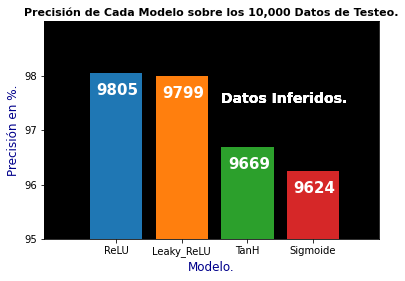

In [181]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_facecolor((0, 0, 0))

modelos = list(range(1, 4+1))
precision_modelos = [P_T_ReLU, P_T_Leaky_ReLU, P_T_TanH, P_T_Sigmoide]
aciertos_modelos = [Aciertos_Testeo_ReLU, Aciertos_Testeo_Leaky_ReLU, Aciertos_Testeo_TanH, Aciertos_Testeo_Sigmoide]

for i,(precision,aciertos) in enumerate(zip(precision_modelos,aciertos_modelos)):
    ax.axis([-0.1,4+1,95,99])
    ax.bar(modelos[i],precision_modelos[i])
    ax.annotate(str(aciertos), xy=(modelos[i],precision_modelos[i]), xytext=(modelos[i]-0.3,precision_modelos[i]-0.4), 
                color="white", fontsize=15, fontweight="bold")
    ax.text(x = 2.6, y = 97.5, s = "Datos Inferidos.", color="white", fontsize=14, fontweight="bold")
    ax.set_yticks(range(95,99))

ax.set_title("Precisión de Cada Modelo sobre los 10,000 Datos de Testeo.", fontsize=11, fontweight="bold")
ax.set_xlabel("Modelo.", fontsize=12, color="darkblue")
ax.set_ylabel("Precisión en %.", fontsize=12, color="darkblue")

plt.xticks(modelos,["ReLU", "Leaky_ReLU", "TanH", "Sigmoide"])
plt.show()

#### **CONCLUSIÓN GENERAL:**  

Para modelos sin regularización y cuyos datos a clasificar sean multi-clase, experimentar con **ReLU** y **Leaky ReLU** en las capas ocultas y **Softmax** en la capa de salida, ya que como se observa, la diferencia en la precisión de ambos modelos es mínima.

***

*Finalmente, realizamos una clasificación binaria sólo para observar el funcionamiento de la F.A. Sigmoide en la capa de salida y en las capa oculta:*

In [188]:
# Compuerta XOR:

D = np.array([[0,0],[0,1],[1,0],[1,1]])
S = np.array([[0],[1],[1],[0]])

In [189]:
Pesos_XOR, Bias_XOR, Errores_XOR, Precision_XOR, FA_CO_XOR, FA_CS_XOR = algoritmo_entrenamiento(D, S, 1500, 1)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  2
Cuántas neuronas deseas para la capa de salida:  1

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) ;  TanH (2) ; Sigmoide (3) 3
Qué función de activación deseas para la capa de salida: Softmax (0) ; Sigmoide (1) 1



La cantidad de lotes a ingresar a la red es: 4.0.

Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 31.5867838436%

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 31.3315783213%

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 31.1831700369%

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 31.0710302424%

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 30.9721020758%

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 30.8785683658%

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 30.7876508178%

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 30.6983659552%

Época: 9
Error Total de la Red sobre los Datos de Entrenamiento: 30.6104392898%

Época: 10
Error Total de la Red sobre los Datos de Entrenamiento: 30.5239081602%

Época: 11
Error Total de la Red sobre los Datos de Entrenamiento: 30.4389564905%

Época: 12
Error Total de la Red sobre los Datos de Entr

In [190]:
Prediccion_XOR, Error_Testeo_XOR = predicciones(Pesos_XOR, Bias_XOR, D, S, FA_CO_XOR, FA_CS_XOR)

In [191]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_XOR, decimals=4)}%.")
print(f"Cantidad de Aciertos sobre el conjunto de Testeo:\n{Prediccion_XOR}")

Error sobre los datos de Testeo: 0.0527%.
Cantidad de Aciertos sobre el conjunto de Testeo:
[[0.02539401]
 [0.97841284]
 [0.97795137]
 [0.02259537]]


Como se observa en el vector de predicción resultante y en el error, nuestro modelo ha aprendido a relacionar la entrada con su respectiva etiqueta.